## Neural Networks
### In-class practise: Systematic data augmentation for images

by Stefan Heinrich
Based on sec 13.1 of http://d2l.ai/chapter_computer-vision/image-augmentation.html and further adaptations by Kevin Murphy in https://github.com/probml/probml-notebooks/blob/main/notebooks-d2l/image_augmentation_torch.ipynb

We illustrate some simple data augmentation methods for images.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

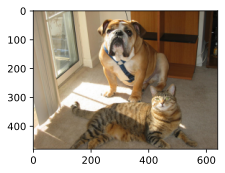

In [2]:
d2l.set_figsize()
#img = d2l.Image.open('../img/cat1.jpg')

#url = 'https://github.com/d2l-ai/d2l-en/blob/master/img/cat1.jpg?raw=true'
url = 'https://github.com/probml/probml-notebooks/blob/main/images/cat_dog.jpg?raw=true'
fname = 'img.jpg'
!wget $url -q -O $fname


img = d2l.Image.open(fname)

d2l.plt.imshow(img);

In [3]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.tight_layout()
    return fig, axes

To visualize an image augmentation, which may be stochastic, we apply it multiple times to an image.


In [4]:

def apply(img, aug, num_rows=1, num_cols=4, scale=2):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    fig, axes = show_images(Y, num_rows, num_cols, scale=scale)
    return fig, axes

# Flipping

(<Figure size 800x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

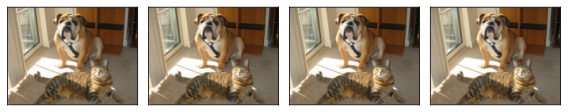

In [5]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

(<Figure size 800x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

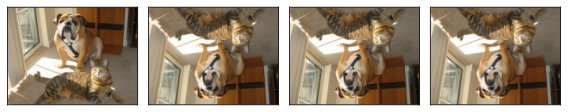

In [6]:
apply(img, torchvision.transforms.RandomVerticalFlip())

# Crop and resize

Below, we randomly crop a region with an area of 10% to 100% of the original area, and the ratio of width to height of the region is randomly selected from between 0.5 and 2. Then, the width and height of the region are both scaled to 200 pixels.


(<Figure size 800x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

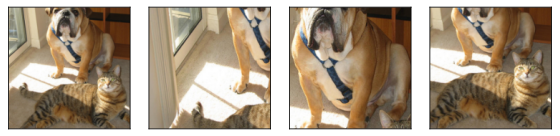

In [7]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

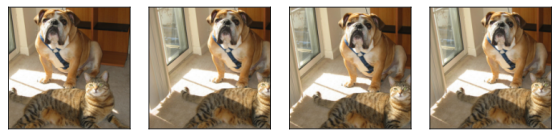

In [8]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.5, 1), ratio=(1, 1))
fig, axes = apply(img, shape_aug)
fig.savefig('dog_cat_augment.png')

# Changing color

We can change brightness, contrast, saturation and hue.
First we change brightness, from 1-0.5=0.5 times less to 1+0.5=1.5 times more.

(<Figure size 800x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

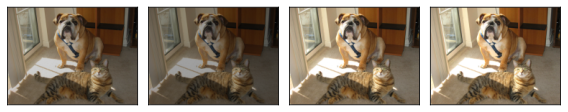

In [9]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0,
                                       saturation=0, hue=0))

Now we change hue.

(<Figure size 800x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

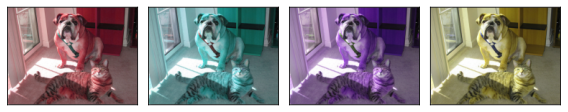

In [10]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0,
                                       hue=0.5))

Now we change saturation.

(<Figure size 800x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

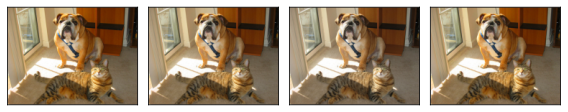

In [11]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0.5,
                                       hue=0))

Now we change contrast.

(<Figure size 800x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

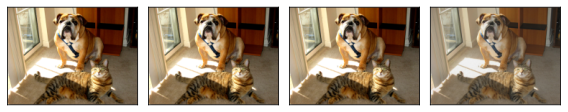

In [12]:
apply(
    img,
    torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0,
                                       hue=0))

Now we change all of them.

(<Figure size 800x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

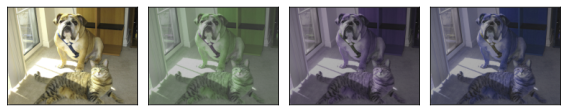

In [13]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5,
                                               saturation=0.5, hue=0.5)
apply(img, color_aug)

# Combining multiple augmentations in a pipeline

(<Figure size 800x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

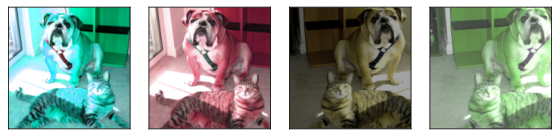

In [14]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

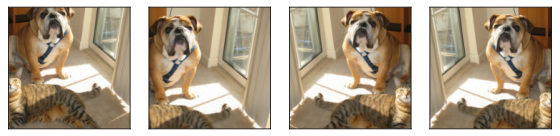

In [15]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), shape_aug])
fig, axes = apply(img, augs)
fig.savefig('dog_cat_augment2.png')

# Using augmentations in a dataloader

We illustrate how we can transform training and test images from FashionMNIST.

100%|██████████| 26421880/26421880 [00:02<00:00, 10358550.41it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211740.06it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3891991.59it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24453314.83it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



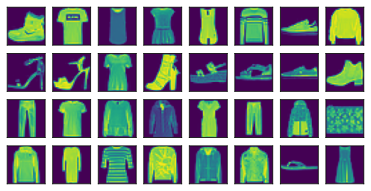

In [16]:
all_images = torchvision.datasets.FashionMNIST(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [17]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

In [18]:
batch_size = 32
dataset = torchvision.datasets.FashionMNIST(root="../data", train=True,
                                       transform=train_augs, download=True)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True,
    num_workers=d2l.get_dataloader_workers())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
NO_images = batch_size

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader)
images, label = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# print images
print("This shows the next batch of images in the training set")
imshow(torchvision.utils.make_grid(images))